In [1]:
!pip install fastdtw

In [0]:
# The essentials
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Access our Google Drive
from google.colab import drive

from fastdtw._fastdtw import fastdtw
import pickle

In [3]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
dtw_distances_3.p
mds_embeddings_2d_3.csv
mds_embeddings_2d_3.p
more_features_with_preds_per_phase.csv
pca_features_with_preds_per_phase.csv
predictions_machine_405.csv
test_features_14.csv
test_features_15.csv
test_features_1.csv
test_features_2.csv
test_features_3.csv
test_features_6.csv
test_features_7.csv
test_features_8.csv
test_features_per_phase_14.csv
test_features_per_phase_15.csv
test_features_per_phase_1.csv
test_features_per_phase_2.csv
test_features_per_phase_3.csv
test_features_per_phase_6.csv
test_features_per_phase_7.csv
test_features_per_phase_8.csv
test_preds_per_phase.p
test_values.csv
train_feature

In [4]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
process_comb = 3

process_comb_to_phases = {
    15: ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid'],
    3:  ['pre_rinse', 'caustic'],
    7:  ['pre_rinse', 'caustic', 'intermediate_rinse'],
    1:  ['pre_rinse'],
    8:  ['acid'],
    2:  ['caustic'],
    6:  ['caustic', 'intermediate_rinse'],
    14: ['caustic', 'intermediate_rinse', 'acid'],
}

ts_cols = [
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    'supply_pump',
    'supply_pre_rinse',
    'supply_caustic',
    'return_caustic',
    'supply_acid',
    'return_acid',
    'supply_clean_water',
    'return_recovery_water',
    'return_drain',
    'object_low_level'
]

#filtered_train_df = train_df[train_df['phase'].isin(process_comb_to_phases[process_comb])]
#filtered_test_df = test_df[test_df['phase'].isin(process_comb_to_phases[process_comb])]

def get_time_series(train_df, cols):
  time_series = []
  for process in set(train_df['process_id']):
    process_data = train_df[train_df['process_id'] == process]
    process_data = process_data.sort_values(by='timestamp')
    time_series.append(process_data[cols].values)
  return time_series


In [0]:
#   for col in ts_cols:
#     train_ts = get_time_series(filtered_train_df, [col])
#     test_ts = get_time_series(filtered_test_df, [col])
#     timeseries = train_ts + test_ts
#     distances = np.zeros((len(timeseries), len(timeseries)))

#     for i in tqdm(range(len(timeseries))):
#       for j in range(len(timeseries)):
#         if i == j:
#           distances[i, j] = 0
#         else:
#           dist, _ = fastdtw(timeseries[i], timeseries[j])
#           distances[i, j] = dist

#     pickle.dump(distances, open('/content/drive/My Drive/Rinse Over Run/dtw_distances_{}_{}.p'.format(col, process_comb), 'wb+'))

In [0]:
filtered_train_df = train_df[train_df['phase'].isin(process_comb_to_phases[process_comb])]
filtered_test_df = test_df[test_df['phase'].isin(process_comb_to_phases[process_comb])]

del train_df
del test_df

train_index = list(set(filtered_train_df['process_id']))
test_index = list(set(filtered_test_df['process_id']))
train_labels = np.log(label_df.loc[train_index])

distances = pickle.load(open('/content/drive/My Drive/Rinse Over Run/dtw_distances_3.p', 'rb'))

# Make symmetrical (alternative: take mean of two distances)
distances_symm = distances.copy()
for i in range(distances.shape[0]):
  for j in range(i):
    avg = (distances[i, j] + distances[j, i]) / 2
    distances_symm[j, i] = avg
    distances_symm[i, j] = avg

In [9]:
from sklearn.svm import LinearSVC

val_index = list(np.random.choice(range(len(train_index)), replace=False, size=int(0.1 * len(train_index))))
train_index = list(set(range(len(train_index))) - set(val_index))


IndexError: ignored

In [21]:
from sklearn.svm import SVR

train_distance_matrix = distances_symm[train_index, :][:, train_index]
val_distance_matrix = distances_symm[val_index, :][:, train_index]

clf = SVR(kernel='precomputed')
clf.fit(train_distance_matrix, train_labels.iloc[train_index])

print(clf.predict(val_distance_matrix))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-2.68561600e+11 -1.48516314e+11 -7.23159268e+10  8.36605807e+10
 -1.82642046e+11  1.86571898e+10  6.40098272e+10  5.68334781e+10
  1.21861493e+10  3.92199794e+10  1.80888520e+10 -6.37681156e+10
  6.25786434e+10 -6.22037620e+10  5.67413478e+10  7.18954847e+10
  8.39963091e+10  6.32389444e+09 -5.72077225e+10  8.43118960e+10
  6.22862442e+10 -1.16245943e+10  7.32267879e+10  8.39938010e+10
  7.10448497e+10 -3.76613639e+11  7.32584413e+10 -1.11496676e+11
 -1.80306356e+11  4.95851057e+10 -1.47494356e+11  8.92833231e+09
 -1.75075806e+10 -2.66380990e+11  3.92107866e+10 -5.53458041e+09
 -3.87871653e+09  2.39253899e+10 -2.70044962e+10 -1.63720669e+11
  8.37779876e+09  2.21355850e+10  3.29759269e+07 -2.91060166e+10
 -9.69262289e+10  4.67273266e+10  3.29197880e+10 -3.67424416e+10
  4.34565637e+10 -1.10960271e+11 -2.29736701e+10  1.24179397e+10
 -4.92959105e+10  1.18189793e+10  6.44115885e+10 -9.32151309e+10
  7.39788628e+10  3.68942617e+10  1.91540021e+10 -3.12393498e+09
  5.51957258e+10  4.05602

In [17]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))
  
print(np.exp(clf.predict(val_distance_matrix)), np.exp(train_labels.iloc[val_index].values.flatten()))

[ 0.  0.  0. inf  0. inf inf inf inf inf inf  0. inf  0. inf inf inf inf
  0. inf inf  0. inf inf inf  0. inf  0.  0. inf  0. inf  0.  0. inf  0.
  0. inf  0.  0. inf inf inf  0.  0. inf inf  0. inf  0.  0. inf  0. inf
 inf  0. inf inf inf  0. inf inf inf  0.  0.  0. inf  0.  0.  0.  0. inf
  0. inf  0. inf inf inf inf  0.  0.  0.  0.  0. inf  0.  0. inf  0. inf
  0. inf inf  0.  0.  0. inf inf  0.  0. inf inf inf inf inf  0. inf inf
  0. inf  0.  0.  0.  0.  0.  0. inf inf inf  0. inf  0.  0. inf  0.  0.
  0.  0.  0.  0.  0. inf  0.  0.  0. inf  0.  0. inf inf inf  0.  0.  0.
 inf  0. inf inf inf  0.  0. inf inf  0.  0.  0. inf inf  0.  0. inf  0.
 inf  0.  0. inf  0. inf  0.  0.  0. inf  0.  0.  0. inf inf  0.  0. inf
  0.  0.  0.  0.  0. inf inf  0.  0.  0. inf inf  0. inf inf inf inf  0.
 inf  0.  0.  0. inf inf  0.  0. inf inf  0. inf  0. inf  0.  0. inf  0.
 inf  0.  0.  0.  0. inf  0. inf inf inf inf  0.  0.  0.  0.  0.  0.  0.
  0. inf inf inf  0. inf  0. inf inf inf  0.  0. in

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [0]:
from sklearn.manifold import MDS
mds = MDS(dissimilarity='precomputed', verbose=1, n_init=3, n_jobs=2)

embeddings = mds.fit_transform(distances_symm)

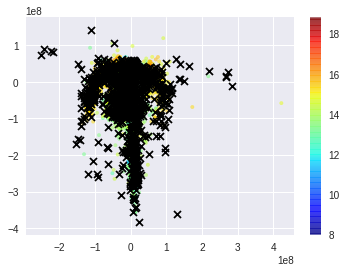

In [0]:
vis_x = embeddings[:len(train_index), 0]
vis_y = embeddings[:len(train_index), 1]
plt.scatter(vis_x, vis_y, c=list(train_labels['final_rinse_total_turbidity_liter'].values), cmap=plt.cm.get_cmap("jet"), marker='.', alpha=0.5)
plt.colorbar()


vis_x = embeddings[len(train_index):, 0]
vis_y = embeddings[len(train_index):, 1]
plt.scatter(vis_x, vis_y, c='k', marker='x')

plt.show()

In [0]:
import pickle

pickle.dump(embeddings, open('/content/drive/My Drive/Rinse Over Run/mds_embeddings_2d_3.p', 'wb+'))

In [0]:
df = pd.DataFrame(np.hstack(
    (
        np.reshape(train_index + test_index, (-1, 1)),
        embeddings
    )
), columns=['process_id', 'mds_0', 'mds_1'])
df['process_id'] = df['process_id'].astype(int)
df = df.set_index('process_id', drop=True)
df.to_csv('/content/drive/My Drive/Rinse Over Run/mds_embeddings_2d_3.csv')

In [0]:
embeddings.shape

(7651, 2)

In [0]:
np.reshape([train_index] + [test_index], (-1, 1)).shape

(2, 1)